# Person - feature selection

There are many methods to select best features to use in the ML algorithms.

I this Notebook I have used following techniques to identify which features have the most meaning when trying to predict the Object Counts:
- Select K-Best
- Feature Importances
- Correlation Matrix

Functions below have been inpired by the [following Notebook](https://github.com/krishnaik06/Feature-Selection-techniques/blob/master/Feature%20Selection.ipynb) published to GitHub by user krishnaik06 in 2019.

There are other techniques for feature selection, like *Forward Selection*, *Backward Elimination* and *Recursive Feature Elimination*, but I will leave those for future exploration.

In [1]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

TF -> Using GPU ->  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Load dataset

In [2]:
filename = '../Datasets/Person_features__2019-09-09_2020-03-02.pickle'
infile = open(filename,'rb')
(numerical, dummies, cyclical, raw_data), y = pickle.load(infile)
infile.close()

### Prepare X and y

- define X and y
- split into traning and testing
- scale data

In [3]:
# handy utility function to merge multiple dataframes
def merge_datasets(datasets):
    """
    Usages:
    - merge_datasets([numerical, dummies, cyclical])
    - merge_datasets([dummies, cyclical])
    - merge_datasets([numerical, dummies])
    """
    df = datasets[0].copy()
    for d_next in datasets[1:]:
        df = df.merge(d_next, left_index=True, right_index=True)
    return df

### Machine Learning linear model (Linear Regression)

Can an ML model pick up on linear relationships between features and improve the baseline model?

In [33]:
from sklearn.linear_model import LinearRegression

# create dataset by merging all features
X = merge_datasets([numerical, dummies, cyclical])
y = raw_data['obs_count_corr']

# split into training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

### Select K-Best using statistical test

Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

The example below uses the ANOVA statistical test for positive and negative features to select 10 of the best features.

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif  # chi2 fails for negative values

In [62]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=20)
fit = bestfeatures.fit(X_train, y_train)

In [63]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [64]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature', 'Score']  #naming the dataframe columns

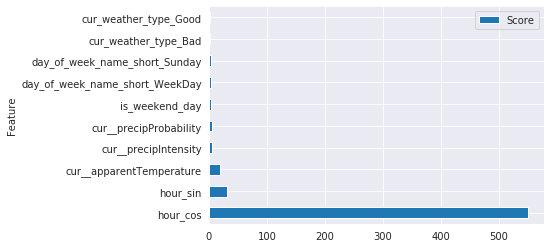

In [67]:
featureScores.sort_values('Score', ascending=False).head(10).set_index('Feature').plot(kind='barh')

In [68]:
best_features = featureScores.sort_values('Score', ascending=False).head(8)['Feature']
best_k_features_list = best_features.values.tolist()
best_k_features_list

['hour_cos',
 'hour_sin',
 'cur__apparentTemperature',
 'cur__precipIntensity',
 'cur__precipProbability',
 'is_weekend_day',
 'day_of_week_name_short_WeekDay',
 'day_of_week_name_short_Sunday']

### Feature Importance

You can get the feature importance of each feature of your dataset by using the feature importance property of the model.

Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.

In [69]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [70]:
print(model.feature_importances_)

[0.00571853 0.06822493 0.07989145 0.07795261 0.07614955 0.08562639
 0.06399364 0.00515484 0.00500348 0.00786653 0.00824771 0.00590945
 0.00587203 0.00663215 0.00601158 0.00593809 0.10120051 0.24846736
 0.03934169 0.02736266 0.03750129 0.03193351]


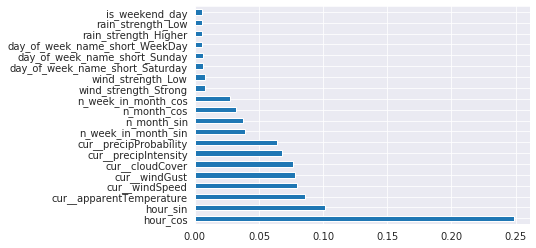

In [71]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [72]:
best_feat_importances = feat_importances.nlargest(12).index.tolist()

In [73]:
# pickle the list and save to disk
filename = 'Person_best_features__2019-09-09_2020-03-02.pickle'
outfile = open(f'../Datasets/{filename}','wb')
data_struct = (best_k_features_list, best_feat_importances)
pickle.dump(data_struct, outfile)
outfile.close()

### Correlation Matrix with Heatmap

Correlation states how the features are related to each other or the target variable.

Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable)

Heatmap makes it easy to identify which features are most related to the target variable, we will plot heatmap of correlated features using the seaborn library.

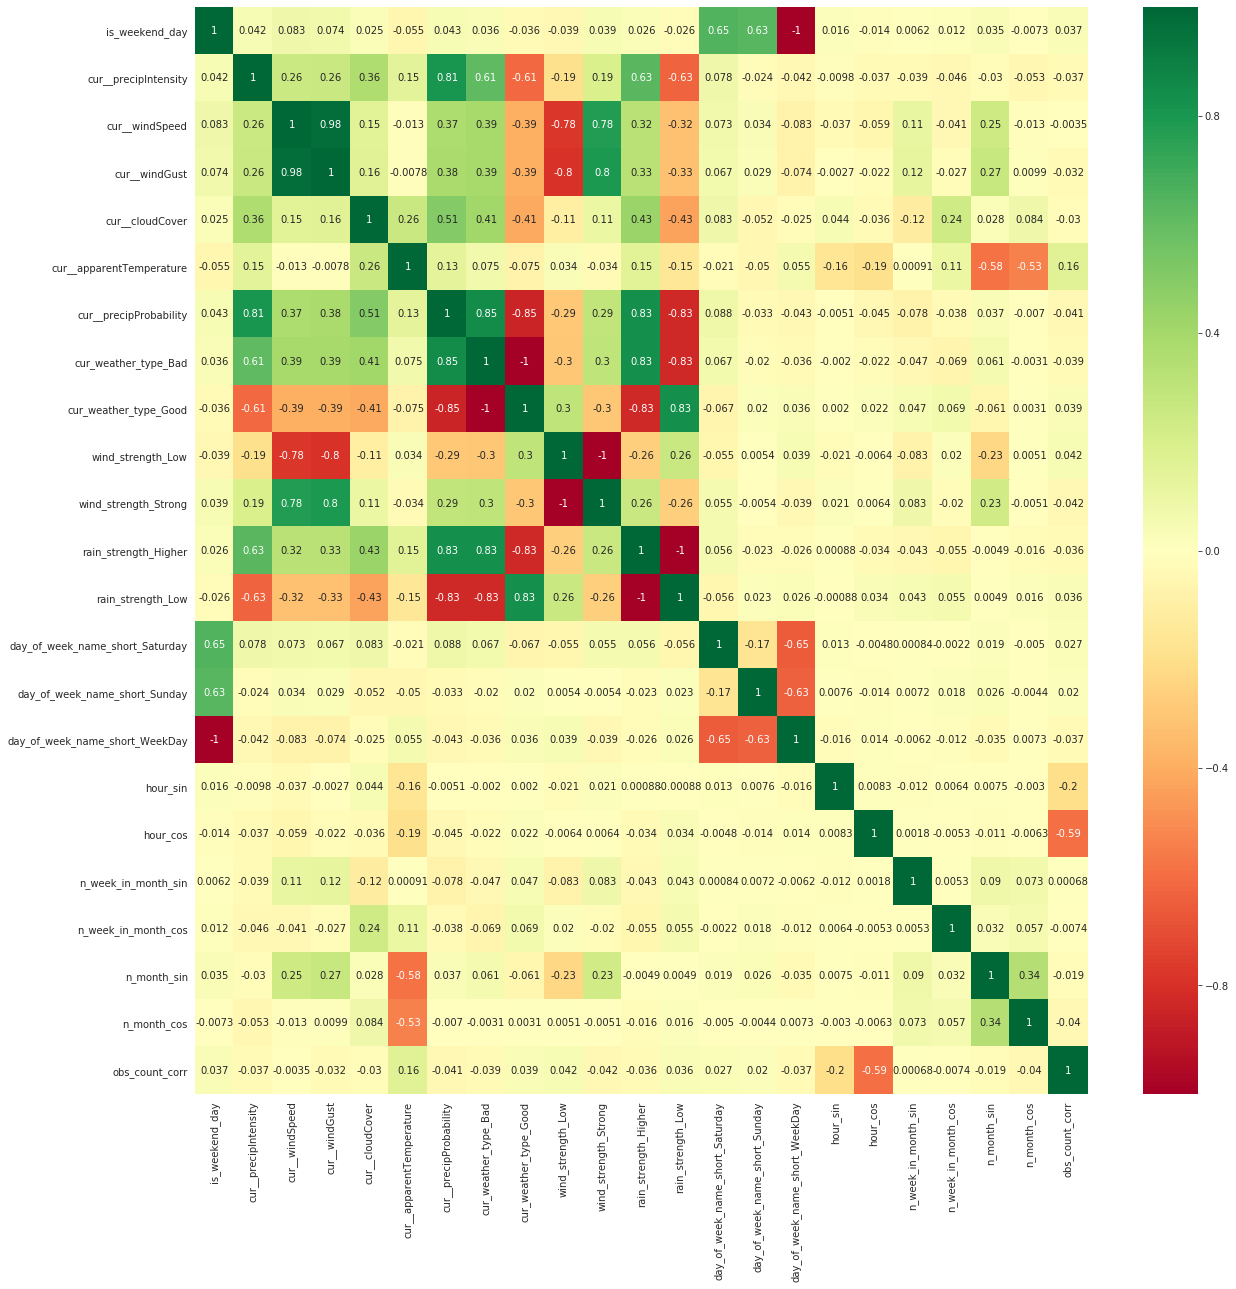

In [74]:
import seaborn as sns

data = X_train.copy()
data['obs_count_corr'] = y_train.astype(float)

#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 20))
#plot heat map
g = sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="RdYlGn")